In [27]:
import random
import joblib
import os
from sklearn.model_selection import train_test_split
from data_reader import MaldiDataset
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    classification_report
)


# Análisis exploratorio

## Carga de datos

In [13]:
# Set all seeds to make the results reproducible
random.seed(42)
np.random.seed(42)


# This script is a simple starting point to classify fungal data using MALDI-TOF spectra.
class SimpleFungusDataLoader:
    def __init__(self, dataset_path, test_size=0.2, random_state=42):
        # Initialize the classifier with dataset path, test size, and random state for reproducibility.
        self.dataset_path = dataset_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.train_data = []
        self.test_data = []

    def load_data(self, n_step):
        # Load the dataset using MaldiDataset
        dataset = MaldiDataset(self.dataset_path, n_step=n_step)
        dataset.parse_dataset()  # Parse the dataset from the specified path
        self.data = dataset.get_data()  # Retrieve the parsed data


    def split_data_stratify(self):
        """
        Divide los datos en train y test de forma estratificada según 'genus_species_label',
        asegurando que no haya solapamiento de 'unique_id_label' entre ambos conjuntos.
        Las clases con menos de 2 instancias se asignan directamente al conjunto de entrenamiento.
        """
        # Convertir los datos en un DataFrame
        df = pd.DataFrame(self.data)

        # Agrupar por 'unique_id_label' y seleccionar una clase representativa ('genus_species_label') para cada grupo
        unique_id_groups = df.groupby('unique_id_label').first().reset_index()

        # Identificar las clases con menos de 2 instancias
        class_counts = unique_id_groups['genus_species_label'].value_counts()
        small_classes = class_counts[class_counts < 2].index

        # Separar los grupos con clases pequeñas y el resto
        small_class_groups = unique_id_groups[unique_id_groups['genus_species_label'].isin(small_classes)]
        remaining_groups = unique_id_groups[~unique_id_groups['genus_species_label'].isin(small_classes)]

        # Estratificar las clases restantes
        train_ids, test_ids = train_test_split(
            remaining_groups['unique_id_label'],
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=remaining_groups['genus_species_label']  # Usar 'genus_species_label' como criterio de estratificación
        )

        # Agregar todas las instancias de clases pequeñas al conjunto de entrenamiento
        train_ids = pd.concat([pd.Series(train_ids), small_class_groups['unique_id_label']])

        # Filtrar el DataFrame original para crear los conjuntos de train y test
        self.train_data = df[df['unique_id_label'].isin(train_ids)]  # DataFrame de entrenamiento
        self.test_data = df[df['unique_id_label'].isin(test_ids)]  # DataFrame de prueba

        # Verificar que no haya solapamiento de 'unique_id_label' entre train y test
        train_unique_ids = set(self.train_data['unique_id_label'])
        test_unique_ids = set(self.test_data['unique_id_label'])
        assert len(train_unique_ids.intersection(test_unique_ids)) == 0, "Unique ID labels overlap between train and test"

        # Imprimir estadísticas
        print(f"Number of unique_id_labels in train data: {len(train_unique_ids)}")
        print(f"Number of unique_id_labels in test data: {len(test_unique_ids)}")
        print(f"Number of samples in train data: {len(self.train_data)}")
        print(f"Number of samples in test data: {len(self.test_data)}")
        print(f"Number of classes to predict: {len(self.train_data['genus_species_label'].unique())}")



    def plot_data_distribution(self):
        """
        Grafica la distribución de las clases ('genus_species_label') en los conjuntos de
        entrenamiento y prueba para visualizar las proporciones después de la división estratificada.
        """
        # Contar las etiquetas en los conjuntos de entrenamiento y prueba
        train_counts = self.train_data['genus_species_label'].value_counts()
        test_counts = self.test_data['genus_species_label'].value_counts()

        # Unificar las etiquetas para asegurar que ambas series tengan los mismos índices
        all_labels = pd.Index(train_counts.index).union(test_counts.index)
        train_counts = train_counts.reindex(all_labels, fill_value=0)
        test_counts = test_counts.reindex(all_labels, fill_value=0)

        # Crear gráfico
        x = np.arange(len(all_labels))  # Posiciones de las barras
        width = 0.4  # Ancho de las barras

        plt.figure(figsize=(14, 8))  # Tamaño del gráfico
        plt.bar(x - width / 2, train_counts, width, label='Train', alpha=0.8, color='blue')
        plt.bar(x + width / 2, test_counts, width, label='Test', alpha=0.8, color='orange')

        # Configurar etiquetas y título
        plt.xlabel('Genus+Species Label', fontsize=12)
        plt.ylabel('Number of Samples', fontsize=12)
        plt.title('Distribution of Genus+Species Labels in Train and Test Data', fontsize=14)
        plt.xticks(x, all_labels, rotation=90, fontsize=10)  # Etiquetas en el eje X
        plt.legend(fontsize=12)

        # Ajustar diseño
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    def get_train_data(self):
        return self.train_data
    
    def get_test_data(self):
        return self.test_data

In [3]:
# Define the dataset path (update this path to where your dataset is located)
dataset_path = "data/fungus_db"

# Initialize the classifier with the dataset path
fungus_identifier = SimpleFungusDataLoader(dataset_path)

fungus_identifier.load_data(n_step=6)

# Load and split the data into training and test sets.
fungus_identifier.split_data_stratify()

c:\Users\aleta\Documents\TFM\FungusClassifier\data_reader.py:299: RuntimeWarning: invalid value encountered in divide
  intensity=SpectrumObj.intensity / SpectrumObj.intensity.sum() * self.sum,


Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Number of unique_id_labels in train data: 268
Number of unique_id_labels in test data: 64
Number of samples in train data: 6452
Number of samples in test data: 1476
Number of classes to predict: 60


## Definiendo especies críticas y de alto riesgo

In [4]:
genus_species_critical = ['Candida auris', 'Cryptococcus neoformans', 'Aspergillus fumigatus']
genus_species_high = ['Mucor circinelloides', 'Fusarium anthophilium', 'Fusarium dimerum'
    'Fusarium faciforme',
    'Fusarium fujikuorii',
    'Fusarium keratoplasticum',
    'Fusarium oxysporum',
    'Fusarium petroliphilum',
    'Fusarium proliferatum',
    'Fusarium solani',
    'Fusarium verticillioides',
]

# Print the updated lists
print("Critical species:")
for species in genus_species_critical:
    print(f"- {species}")
    
print("\nHigh risk species:")
for species in genus_species_high:
    print(f"- {species}")

Critical species:
- Candida auris
- Cryptococcus neoformans
- Aspergillus fumigatus

High risk species:
- Mucor circinelloides
- Fusarium anthophilium
- Fusarium dimerumFusarium faciforme
- Fusarium fujikuorii
- Fusarium keratoplasticum
- Fusarium oxysporum
- Fusarium petroliphilum
- Fusarium proliferatum
- Fusarium solani
- Fusarium verticillioides


In [5]:
genus_critical = ['Candida', 'Cryptococcus', 'Aspergillus']
genus_high = ['Mucor', 'Fusarium']

# Print the updated lists
print("Critical genus:")
for genus in genus_critical:
    print(f"- {genus}")

print("\nHigh risk genus:")
for genus in genus_high:
    print(f"- {genus}")

Critical genus:
- Candida
- Cryptococcus
- Aspergillus

High risk genus:
- Mucor
- Fusarium


## Estudio distribución de clases

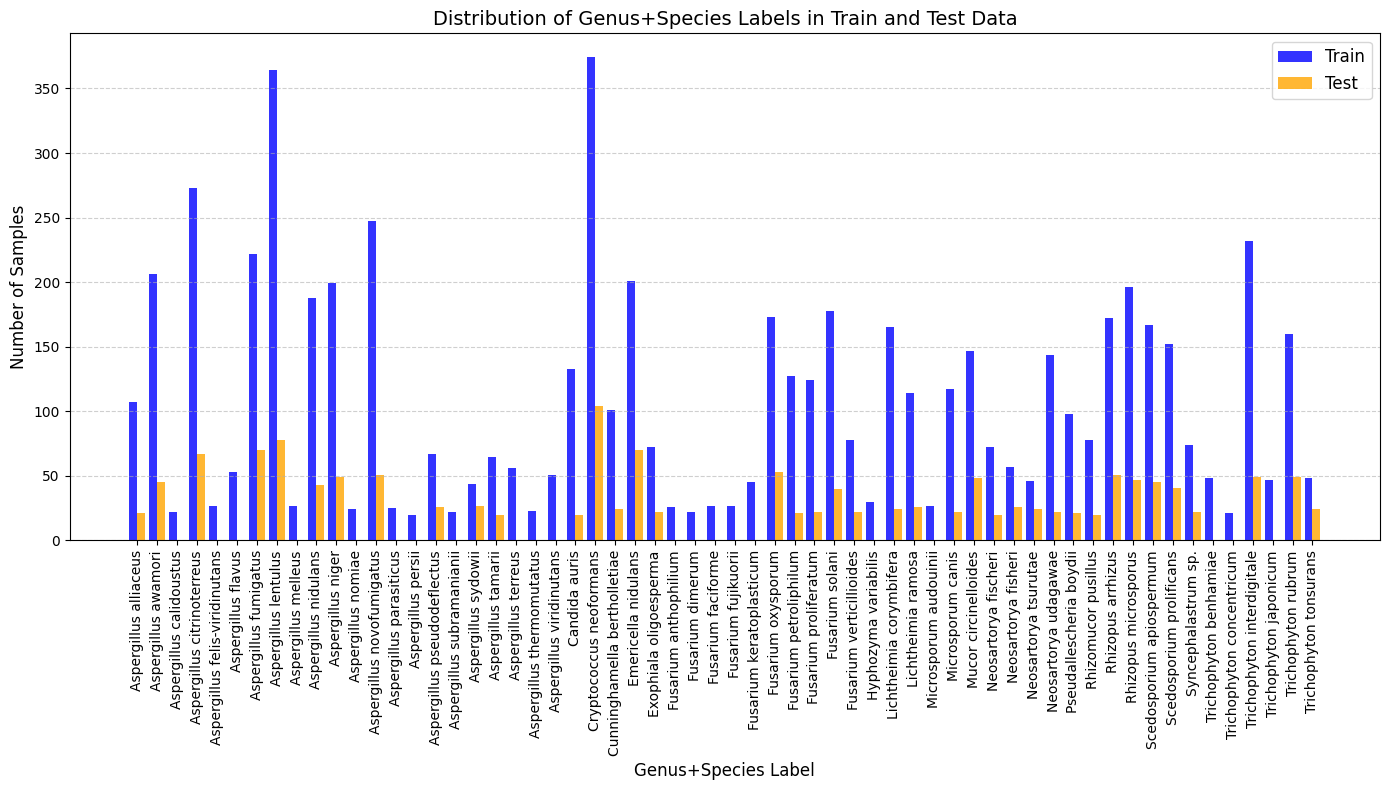

In [6]:
fungus_identifier.plot_data_distribution()

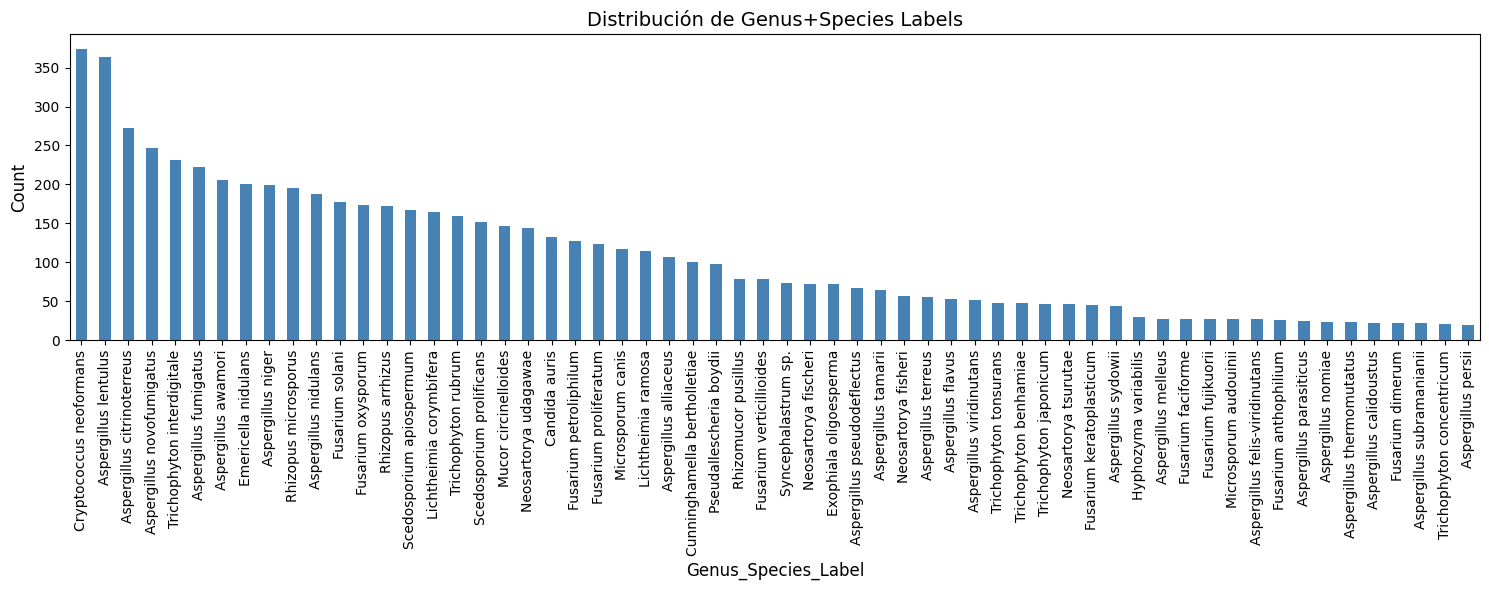

In [7]:
# Crear el gráfico de barras
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico
fungus_identifier.train_data['genus_species_label'].value_counts().plot(kind='bar', color='steelblue')

# Rotar las etiquetas del eje X para que no se solapen
plt.xticks(rotation=90, fontsize=10)  # Rotar 90 grados y ajustar el tamaño de fuente

# Agregar etiquetas y título
plt.xlabel('Genus_Species_Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribución de Genus+Species Labels', fontsize=14)

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()

# Mostrar el gráfico
plt.show()


<Axes: xlabel='genus_label'>

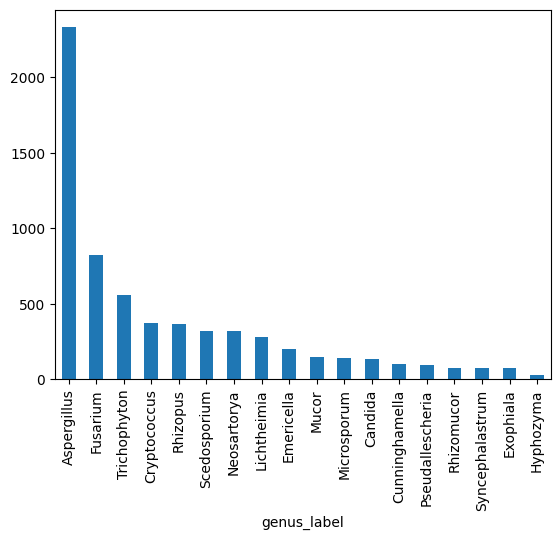

In [8]:
fungus_identifier.train_data['genus_label'].value_counts().plot(kind='bar')

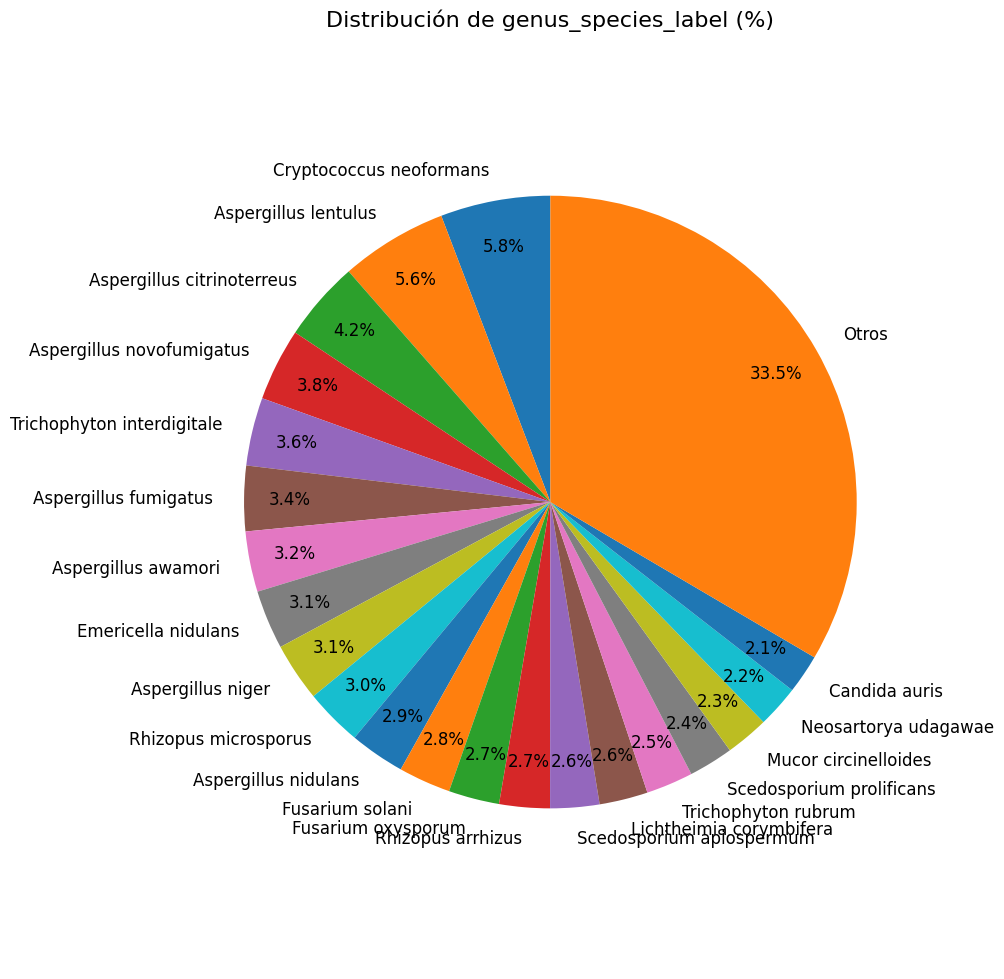

In [9]:
# Calcular los conteos y porcentajes
value_counts = fungus_identifier.train_data['genus_species_label'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Agrupar categorías pequeñas
threshold = 2  # Porcentaje mínimo para mostrar individualmente
large_categories = percentages[percentages >= threshold]
small_categories = percentages[percentages < threshold].sum()
percentages_filtered = pd.concat([large_categories, pd.Series({'Otros': small_categories})])

# Crear el gráfico circular con líneas de conexión
plt.figure(figsize=(10, 10))  # Aumentar el tamaño del gráfico
plt.pie(
    percentages_filtered,
    labels=percentages_filtered.index,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12},
    pctdistance=0.85,  # Porcentajes más cerca del centro
    labeldistance=1.1  # Etiquetas más alejadas del centro
)
plt.title('Distribución de genus_species_label (%)', fontsize=16)
plt.axis('equal')  # Asegurar que el gráfico sea circular
plt.tight_layout()  # Ajustar elementos automáticamente
plt.show()

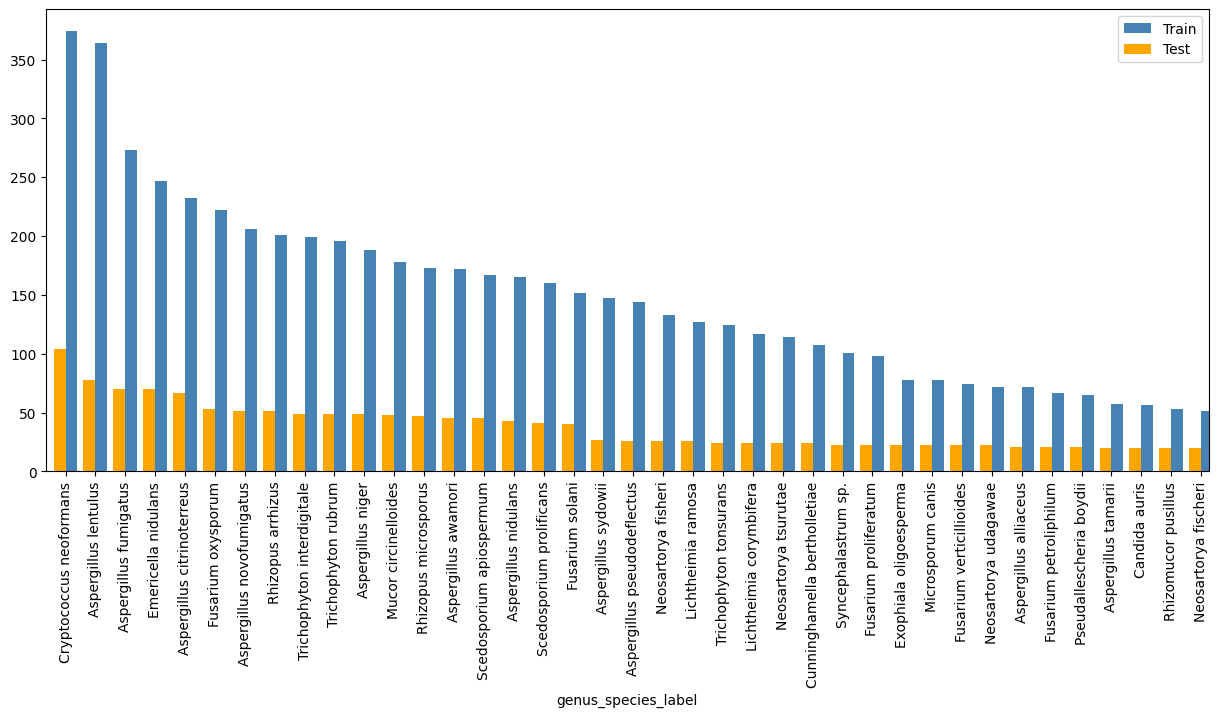

In [10]:
#Comparar la distribución de las etiquetas en los conjuntos de entrenamiento y prueba
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico
fungus_identifier.train_data['genus_species_label'].value_counts().plot(kind='bar', color='steelblue', position=0, width=0.4, label='Train')
fungus_identifier.test_data['genus_species_label'].value_counts().plot(kind='bar', color='orange', position=1, width=0.4, label='Test')
plt.legend()

# Preprocesamiento de datos

In [11]:
train_data = fungus_identifier.get_train_data()
test_data = fungus_identifier.get_test_data()
print(f"Test data shape: {test_data.shape}")
print(f"Train data shape: {train_data.shape}")

Test data shape: (1476, 5)
Train data shape: (6452, 5)


## Codificando numéricamente las etiquetas

In [14]:
label_encoder_genus = LabelEncoder()
label_encoder_genus_species = LabelEncoder()

X = train_data.drop(columns=['genus_species_label', 'genus_label'])
y_species = label_encoder_genus_species.fit_transform(train_data['genus_species_label'])
y_genus = label_encoder_genus.fit_transform(train_data['genus_label'])

## Eliminando columnas m/z y unique_id_label

### Creando transformador personalizado para eliminar las columnas innecesarias

In [15]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    Transformer que elimina columnas por nombre.
    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Se espera un pandas DataFrame
        return X.drop(columns=self.columns, errors='ignore')

## Creando una columna para cada valor del espectro

In [16]:
train_data['spectrum']

0       [0.0022636201918124353, 0.005722074038838838, ...
1       [0.002091315749178803, 0.005813570452719158, 0...
2       [0.0014357667301073194, 0.004573081526006474, ...
3       [0.0018279853432873092, 0.004338944188615056, ...
4       [0.0022844036693913756, 0.004587857169049415, ...
                              ...                        
7923    [0.0011182555270965102, 0.00039615825535114265...
7924    [0.0012396259113391249, 0.0004009885173193131,...
7925    [0.001023758266228797, 0.00044711285995063154,...
7926    [0.0013665472584009737, 0.00042831639487453263...
7927    [0.0011755108619971168, 0.0005719858038600177,...
Name: spectrum, Length: 6452, dtype: object

### Creando un transformador personalizado que se encargue de hacer esta operación en el pipeline

In [17]:
class SpectrumExpander(BaseEstimator, TransformerMixin):
    """
    Transforma X de DataFrame con una columna 'spectrum' (listas/ndarrays)
    en un DataFrame donde se ocupa cada posición de 'spectrum' como una
    columna numérica separada y se elimina la columna original.
    """
    def __init__(self, spectrum_col: str = "spectrum"):
        self.spectrum_col = spectrum_col

    def fit(self, X, y=None):
        # No hay nada que aprender
        return self

    def transform(self, X):
        # Asumimos X es un DataFrame de pandas
        # 1) Expandir la columna spectrum en un DF de columnas numéricas
        spec = pd.DataFrame(
            X[self.spectrum_col].tolist(),
            index=X.index,
            columns=[f"spectrum_{i}" for i in range(len(X.iloc[0, :][self.spectrum_col]))]
        )
        # 2) Concatenar y eliminar la columna original
        X_expanded = pd.concat([X.drop(columns=[self.spectrum_col]), spec], axis=1)
        return X_expanded

## Escalado de los datos

### Creando transformador personalizado para el escalado

In [18]:
class IntensityScaler(BaseEstimator, TransformerMixin):
    """
    Multiplica todas las columnas numéricas
    de entrada por un factor fijo.
    """
    def __init__(self, factor=1e4):
        self.factor = factor

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X * self.factor

## Estandarización de los datos por muestra

### Creando transformador personalizado para la estandarización por muestra

In [19]:
class TICLogTransformer(BaseEstimator, TransformerMixin):
    """
    Normaliza cada fila por su suma (TIC) y luego aplica log1p.
    X puede ser DataFrame o array; la salida es del mismo tipo.
    """
    def __init__(self, eps: float = 1e-8):
        self.eps = eps

    def fit(self, X, y=None):
        # No aprende nada
        return self

    def transform(self, X):
        # Si recibimos numpy, lo convertimos a DataFrame para usar div(axis=0)
        is_df = isinstance(X, pd.DataFrame)
        if not is_df:
            X = pd.DataFrame(X)
        # 1) TIC: divide cada valor por la suma de su fila (más eps)
        tic = X.div(X.sum(axis=1) + self.eps, axis=0)
        # 2) log1p
        out = np.log1p(tic)
        # Si era array, devolvemos array; si DataFrame, devolvemos DataFrame con mismos index/cols
        if not is_df:
            return out.values
        out.index, out.columns = X.index, X.columns
        return out

## Estandarización por feature

### Probando una batería de modelos para decidir si estandarizamos por feature o no

In [20]:
preproc = Pipeline([
    ('drop_cols',       ColumnDropper(['m/z', 'unique_id_label', 'genus_label','genus_species_label'])),
    ('spectrum_expand', SpectrumExpander('spectrum')),
    ('intensity_scale', IntensityScaler(factor=1e4)),
    ('tic_log',         TICLogTransformer(eps=1e-8)),
])

y = y_species

base_models = {
    "KNN"         : KNeighborsClassifier(n_neighbors=5),
    "LinearSVC"   : LinearSVC(dual=False),
    "RandomForest": RandomForestClassifier(n_jobs=-1),
    "HistGB"      : HistGradientBoostingClassifier(max_depth=3, learning_rate=0.1),
    "GaussianNB"  : GaussianNB()
}

In [21]:
models_only = {}
models_scaled = {}

for name, clf in base_models.items():
    # a) pipeline solo con tu preprocesado
    models_only[name] = Pipeline([
        ('preproc', preproc),
        ('clf',     clf)
    ])
    # b) idem + escalado global de features antes del clasificador
    models_scaled[name] = Pipeline([
        ('preproc', preproc),
        ('scaler',  StandardScaler()),
        ('clf',     clf)
    ])

In [22]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(model_dict, X, y, cv, tag):
    print(f"\n=== {tag} ===")
    results = {}
    for name, model in model_dict.items():
        scores = cross_val_score(
            model, X, y,
            cv=cv,
            scoring="f1_macro",
            n_jobs=-1,
            verbose=1
        )
        mean, std = scores.mean(), scores.std()
        results[name] = (mean, std)
        print(f"{name:12s}  F1_macro = {mean:.3f} ± {std:.3f}")
    return results

In [23]:
res_only   = evaluate(models_only,   X, y, cv, "TIC+log (solo sample‑wise)")
res_scaled = evaluate(models_scaled, X, y, cv, "TIC+log + StandardScaler(feature‑wise)")


=== TIC+log (solo sample‑wise) ===


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KNN           F1_macro = 1.000 ± 0.000


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


LinearSVC     F1_macro = 0.594 ± 0.007


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


RandomForest  F1_macro = 1.000 ± 0.000


KeyboardInterrupt: 

Debido a los resultados vamos a usar estandarización por feature también por lo que la incorporaremos al pipeline

In [24]:
preproc = Pipeline([
    ('drop_cols',       ColumnDropper(['m/z', 'unique_id_label', 'genus_label','genus_species_label'])),
    ('spectrum_expand', SpectrumExpander('spectrum')),
    ('intensity_scale', IntensityScaler(factor=1e4)),
    ('tic_log',         TICLogTransformer(eps=1e-8)),
    ('std',         StandardScaler())
])

In [25]:
joblib.dump(preproc, "preproc.pkl")

['preproc.pkl']

# Modelos clasicos

In [26]:
def evaluate_with_cross_validation(pipe, X_df, y, n_splits=6, random_state=42):
    """
    Evalúa un pipeline con StratifiedKFold, calculando métricas globales y por clase,
    y comprobando duplicados exactos entre train/test en cada fold.
    
    Parámetros
    ----------
    pipe       : Pipeline de sklearn (preproc + clf)
    X_df       : pandas.DataFrame con las features crudas
    y          : array‑like 1D de etiquetas codificadas
    n_splits   : int, número de folds
    random_state : semilla para reproducibilidad
    
    Devuelve
    -------
    df_global  : DataFrame con métricas globales por fold
    df_class   : DataFrame con métricas por clase por fold
    """
    cv = StratifiedKFold(n_splits=n_splits,
                         shuffle=True,
                         random_state=random_state)
    
    # Preparar estructuras
    global_metrics = []
    per_class      = []
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_df, y), start=1):
        # 1) Chequeo de índices
        assert set(train_idx).isdisjoint(test_idx), \
            f"Fold {fold}: overlap de índices!"
        
        # 3) Extraer splits como DataFrame/array
        X_train = X_df.iloc[train_idx]
        X_test  = X_df.iloc[test_idx]
        y_train = y[train_idx]
        y_test  = y[test_idx]
        
        # 4) Ajustar pipeline y predecir
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        # 5) Métricas globales
        global_metrics.append({
            "fold":             fold,
            "accuracy":         accuracy_score(y_test, y_pred),
            "precision_macro":  precision_score(y_test, y_pred, average="macro", zero_division=0),
            "recall_macro":     recall_score(y_test, y_pred, average="macro", zero_division=0),
            "f1_macro":         f1_score(y_test, y_pred, average="macro", zero_division=0),
            "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        })
        
        # 6) Métricas por clase
        report = classification_report(
            y_test, y_pred, output_dict=True, zero_division=0
        )
        for cls, m in report.items():
            if cls in ("accuracy", "macro avg", "weighted avg"):
                continue
            per_class.append({
                "fold":     fold,
                "class":    cls,
                "precision": m["precision"],
                "recall":    m["recall"],
                "f1":        m["f1-score"],
                "support":   m["support"]
            })
        
        # 7) Opcional: muestra el report texto de este fold
        print(f"\n--- Fold {fold} ---")
        print(classification_report(y_test, y_pred, zero_division=0))
    
    # 8) DataFrames finales
    df_global = pd.DataFrame(global_metrics).set_index("fold")
    df_class  = pd.DataFrame(per_class)
    
    # 9) Resúmenes
    print("\nMétricas globales por fold:")
    print(df_global)
    print("\nResumen global (media ± std):")
    print(df_global.agg(["mean","std"]))
    print("\nMétricas por clase (media ± std sobre folds):")
    print(
        df_class
          .groupby("class")[["precision","recall","f1"]]
          .agg(["mean","std"])
    )
    
    return df_global, df_class


## KNNClassifier

### Aleatorio

In [ ]:
knn_classifier = KNeighborsClassifier()
knn_pipeline = Pipeline([
    ('preproc', preproc),
    ('clf', knn_classifier)
]
)
x_df = train_data.copy()
print(type(x_df))
evaluate_with_cross_validation(knn_pipeline, x_df, y_species, n_splits=6, random_state=42)

In [27]:
if not os.path.exists("bin_6_models_pipelines"):
    os.makedirs("bin_6_models_pipelines")

joblib.dump(knn_pipeline, "./bin_6_models_pipelines/6_bin_knn_pipeline.pkl")

['./bin_6_models_pipelines/6_bin_knn_pipeline.pkl']

## Random Forest

### Aleatorio

In [28]:
random_forest_classifier = RandomForestClassifier(n_jobs=-1)
rf_pipeline = Pipeline([
    ('preproc', preproc),
    ('clf', random_forest_classifier)
]
)
evaluate_with_cross_validation(rf_pipeline, x_df, y_species, n_splits=6, random_state=42)


--- Fold 1 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        46
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00        37
           7       1.00      1.00      1.00        61
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        32
          10       1.00      1.00      1.00        33
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00        41
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00         3
          1

(      accuracy  precision_macro  recall_macro  f1_macro  balanced_accuracy
 fold                                                                      
 1          1.0              1.0           1.0       1.0                1.0
 2          1.0              1.0           1.0       1.0                1.0
 3          1.0              1.0           1.0       1.0                1.0
 4          1.0              1.0           1.0       1.0                1.0
 5          1.0              1.0           1.0       1.0                1.0
 6          1.0              1.0           1.0       1.0                1.0,
      fold class  precision  recall   f1  support
 0       1     0        1.0     1.0  1.0     18.0
 1       1     1        1.0     1.0  1.0     35.0
 2       1     2        1.0     1.0  1.0      3.0
 3       1     3        1.0     1.0  1.0     46.0
 4       1     4        1.0     1.0  1.0      4.0
 ..    ...   ...        ...     ...  ...      ...
 355     6    55        1.0     1.0  1.0 

In [29]:
if not os.path.exists("bin_6_models_pipelines"):
    os.makedirs("bin_6_models_pipelines")
joblib.dump(rf_pipeline, "./bin_6_models_pipelines/6_bin_rf_pipeline.pkl")

['./bin_6_models_pipelines/6_bin_rf_pipeline.pkl']

## SVM

In [31]:
svm_classifier = SVC(kernel='rbf')

x_df = train_data.copy()

svm_pipeline = Pipeline([
    ('preproc', preproc),
    ('clf', svm_classifier)
]
)
evaluate_with_cross_validation(svm_pipeline, x_df, y_species, n_splits=6, random_state=42)


--- Fold 1 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        46
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00        37
           7       1.00      1.00      1.00        61
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        32
          10       1.00      1.00      1.00        33
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00        41
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00         3
          1

(      accuracy  precision_macro  recall_macro  f1_macro  balanced_accuracy
 fold                                                                      
 1     1.000000         1.000000      1.000000  1.000000           1.000000
 2     1.000000         1.000000      1.000000  1.000000           1.000000
 3     1.000000         1.000000      1.000000  1.000000           1.000000
 4     1.000000         1.000000      1.000000  1.000000           1.000000
 5     0.997209         0.998686      0.992906  0.994946           0.992906
 6     0.998140         0.999487      0.991667  0.994184           0.991667,
      fold class  precision  recall   f1  support
 0       1     0        1.0     1.0  1.0     18.0
 1       1     1        1.0     1.0  1.0     35.0
 2       1     2        1.0     1.0  1.0      3.0
 3       1     3        1.0     1.0  1.0     46.0
 4       1     4        1.0     1.0  1.0      4.0
 ..    ...   ...        ...     ...  ...      ...
 355     6    55        1.0     1.0  1.0 

In [32]:
if not os.path.exists("bin_6_models_pipelines"):
    os.makedirs("bin_6_models_pipelines")
joblib.dump(svm_pipeline, "./bin_6_models_pipelines/6_bin_svm_pipeline.pkl")

['./bin_6_models_pipelines/6_bin_svm_pipeline.pkl']

# PCA para visualización 3D

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
from IPython.display import IFrame

# 1) Preprocesado de features usando tu pipeline
X_proc = preproc.fit_transform(train_data)

# 2) PCA a 3 componentes
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_proc)

# 3) DataFrame para graficar
df_vis = pd.DataFrame(X_pca, columns=['PC1','PC2','PC3'])
df_vis['genus']   = label_encoder_genus.inverse_transform(y_genus)
df_vis['species'] = label_encoder_genus_species.inverse_transform(y_species)

# 4) Grafico 3D interactivo – Género
fig_genus = px.scatter_3d(
    df_vis, x='PC1', y='PC2', z='PC3',
    color='genus',
    title='PCA 3D interactivo – Género',
    labels={'genus':'Género'}
)

if not os.path.exists("bin_6_pca"):
    os.makedirs("bin_6_pca")

# 5) O si prefieres guardarlo como HTML y luego incrustarlo:
html_path = "./bin_6_pca/bin_6_pca_genus.html"

display(IFrame(html_path, width=800, height=600))

# 6) Mismo para Especie
fig_species = px.scatter_3d(
    df_vis, x='PC1', y='PC2', z='PC3',
    color='species',
    title='PCA 3D interactivo – Especie',
    labels={'species':'Especie'}
)

html_path2 = "./bin_6_pca/bin_6_pca_species.html"


fig_species.write_html(html_path2, include_plotlyjs='cdn')
fig_genus.write_html(html_path, include_plotlyjs='cdn')


# TSNE3 para visualizacion 3D

In [32]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px
from IPython.display import IFrame
import plotly.io as pio
import os

# 0) Forzamos renderer interactivo
pio.renderers.default = "iframe_connected"

# 1) Creamos directorio si no existe
if not os.path.exists("bin_6_tsne3"):
    os.makedirs("bin_6_tsne3")

# 2) Preprocesado de features usando tu pipeline
X_proc = preproc.fit_transform(train_data)

# 3) t‑SNE a 3 componentes
tsne = TSNE(n_components=3, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_proc)

# 4) DataFrame para graficar
df_vis = pd.DataFrame(X_tsne, columns=['TSNE1','TSNE2','TSNE3'])
df_vis['genus']   = label_encoder_genus.inverse_transform(y_genus)
df_vis['species'] = label_encoder_genus_species.inverse_transform(y_species)

# 5) Gráfico 3D interactivo – Género
fig_genus = px.scatter_3d(
    df_vis,
    x='TSNE1', y='TSNE2', z='TSNE3',
    color='genus',
    title='t-SNE 3D interactivo – Género',
    labels={'genus':'Género'}
)
html_path = "./bin_6_tsne3/tsne3_genus.html"
fig_genus.write_html(html_path, include_plotlyjs='cdn')

# 6) Gráfico 3D interactivo – Especie
fig_species = px.scatter_3d(
    df_vis,
    x='TSNE1', y='TSNE2', z='TSNE3',
    color='species',
    title='t-SNE 3D interactivo – Especie',
    labels={'species':'Especie'}
)
html_path2 = "./bin_6_tsne3/tsne3_species.html"
fig_species.write_html(html_path2, include_plotlyjs='cdn')
